# Homework #4
Problems: 7.2,7.3,7.4,7.6,7.8,9.2

Josh Cohen

In [144]:
# import numpy as np
import autograd.numpy as np
from autograd import grad
import pandas as pd
import sympy as sym
import math
%matplotlib notebook
from matplotlib import pyplot as plt

from IPython.display import Image

## Problem 7.2

In [2]:
df = pd.read_csv("4class_data.csv", header=None, index_col=None)

In [3]:
C = 4
N = 2
OHE = np.eye(C)

W_sym = sym.MatrixSymbol('\widetilde{w}', N+1, C).as_explicit()
xp_tilde = sym.MatrixSymbol('\widetilde{x}', N,1).as_explicit()
yp_Mat = sym.eye(4)

yp = sym.symbols('y_p')
xp_tilde = sym.MatrixSymbol('\widetilde{x_p}', N + 1, 1).as_explicit()
w_tilde = sym.MatrixSymbol('\widetilde{w}', N + 1, 1).as_explicit()

In [4]:
cost = sym.Matrix([sym.log(1 + sym.exp(-yp * xp_tilde.T * w_tilde)[0])])
grad_cost = cost.jacobian(w_tilde)
cost_lam = sym.lambdify([yp, xp_tilde, w_tilde], cost)
grad_cost_lam = sym.lambdify([yp, xp_tilde, w_tilde],grad_cost)

In [5]:
yps_multiclass = df.iloc[:,-1]
P = yps_multiclass.shape[0]

xp_tildes = np.concatenate((np.ones((P,1)) ,df.iloc[:,:2].to_numpy()), axis=1).T
xp_tildes[:,0]

array([1.     , 0.12558, 0.75948])

In [6]:
def get_w_OvA(c):
    class_indexs = df.index[df.iloc[:,-1] == c]
    OvA_yps = pd.DataFrame(np.zeros(P) -1)
    OvA_yps.iloc[class_indexs] =1
    return np.squeeze(OvA_yps.to_numpy())

In [7]:
def cost_func(w_tilde, yps):
    cost_sum = 0
    for i in range(P):
        cost_sum += cost_lam(yps[i], xp_tildes[:,i], w_tilde)  * 1/P
    ans = np.squeeze(cost_sum,axis=1)
    return ans

In [8]:
get_w_OvA(2).shape

(40,)

In [9]:
def grad_cost_func(w_tilde, yps):
    grad_cost_sum = np.zeros(N + 1)
    for i in range(P):
        grad_cost_sum += np.squeeze(grad_cost_lam(yps[i], xp_tildes[:,i], w_tilde),axis=0) * 1/P
    return grad_cost_sum 

In [10]:
def grad_desc(w_last, yps):
    eps = 10e-5
    max_its = 50000
    cost_vals = np.zeros(max_its)
    num_its = 0
    cost_vals[0] = cost_func(w_last, yps)
    grad_last = grad_cost_func(w_last, yps)
    num_its += 1

    while(np.linalg.norm(grad_last) > eps):
        w_next = w_last - .1 *grad_last
        num_its += 1
        if (num_its > max_its):
            print("hit max its")
            break;
        
        w_last = w_next
#         cost_vals[num_its] = cost_func(w_last, yps)
        grad_last = grad_cost_func(w_last, yps)
#         print(np.linalg.norm(grad_last))
    
    
    return w_last, cost_vals, num_its

In [11]:
W = np.ones((N+1, C))
yp = get_w_OvA(3)
for i in range(4):
    yps = get_w_OvA(i+1)
    W[:,i], costs, its = grad_desc(W[:,i], yps)

hit max its
hit max its


In [12]:
def confusion_matrix_gen(w_tilde, yps):
    confusion_matrix = pd.DataFrame(np.zeros((2,2)), index=["a_bad", "a_good"], columns=["p_bad", "p_good"]).astype('int')
    for i in range(P):
        xp_tilde = xp_tildes[:,i]
        yp = yps[i]
        #correctly predicted
        if np.sign(np.matmul(xp_tilde.T, w_tilde)) == np.sign(yp):
            #pg, ag
            if (yp > 0):
                confusion_matrix.loc["a_good", "p_good"] += 1
            else:
                confusion_matrix.loc["a_bad", "p_bad"] += 1
                
        else:
            if (yp > 0):
                confusion_matrix.loc["a_good", "p_bad"] += 1
            else:
                confusion_matrix.loc["a_bad", "p_good"] += 1
                
    return confusion_matrix

In [13]:
c = 0
confusion_matrix = confusion_matrix_gen(W[:,c],get_w_OvA(c+1))
confusion_matrix

,p_bad,p_good
a_bad,28,2
a_good,2,8


In [14]:
x_tildes = xp_tildes
class_list = np.zeros(P)
for pt in range(P):
    max_dist = 0
    for c in range(C):
        dist = np.matmul(x_tildes[:,pt].T, W[:,c])
        if (dist > max_dist):
            class_list[pt] = c



In [15]:
def number_misclass(class_list):
    misclass = 0
    for c in range(C):
        for i in class_list[10*c:10*(c+1)]:
            if i != c:
#                 print("misclass: {} as: {}".format())
                misclass+=1
    return misclass

In [16]:
number_misclass(class_list)

13

Therefore OvA classifier misclasified 13 elemnts

In [17]:
x, y = sym.symbols('x y')
x_sym = sym.Matrix([1, x, y])
xvals = np.linspace(0,.9,100)
yvals = np.zeros((4,100))
for i in range(C):
    jarm = sym.Matrix(x_sym.T * W[:,i])
    getyvals = sym.lambdify([x], -1/jarm[2].args[0]* (jarm[1] + jarm[0]))
    yvals[i,:] = getyvals(xvals)

<IPython.core.display.Javascript object>


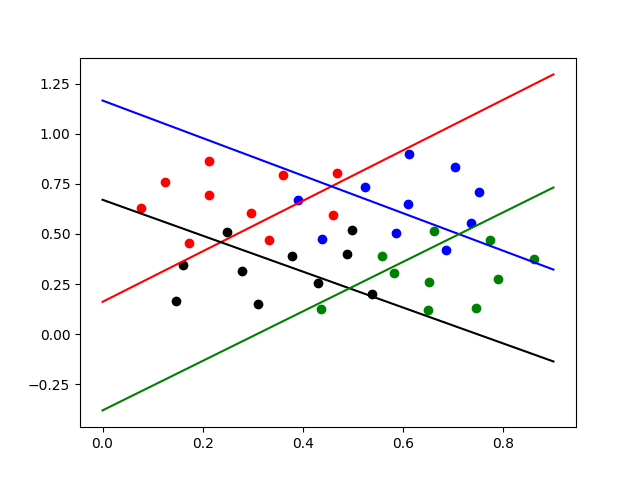

In [18]:
plt.figure()
plt.scatter(xp_tildes[1,:10],xp_tildes[2,:10], color='r')
plt.scatter(xp_tildes[1,10:20],xp_tildes[2,10:20], color='b')
plt.scatter(xp_tildes[1,20:30],xp_tildes[2,20:30], color='k')
plt.scatter(xp_tildes[1,30:40],xp_tildes[2,30:40], color='g')
plt.plot(xvals,yvals[0,:], color='r')
plt.plot(xvals,yvals[1,:], color='b')
plt.plot(xvals,yvals[2,:], color='k')
plt.plot(xvals,yvals[3,:], color='g')

plt.show()

## Problem 7.3

In [96]:
df = pd.read_csv("3class_data.csv", header=None, index_col=None)
N = df.shape[0] -1
P = df.shape[1]
C = 3

W = np.random.rand(N+1,C)
W_yp = np.eye(C) 

x_tildes = np.concatenate((np.ones((P,1)).T, df.iloc[:2, :].to_numpy()), axis=0)

x_p_tilde = sym.MatrixSymbol('\widetilde{x_p}', N+1, 1).as_explicit()
w = sym.MatrixSymbol('w', N+1, 1).as_explicit()

In [97]:
W

array([[0.51773733, 0.2812935 , 0.75149829],
       [0.71741216, 0.24327819, 0.01467621],
       [0.67168055, 0.35068683, 0.44381238]])

In [122]:
def softmax_cost(W):
    cost_sum = 0
    for p in range(P):
        inner_sum = 0
        for c in range(C):
            inner_sum += np.exp(np.matmul(x_tildes[:,p].T, W[:,c]))
        w_yp = np.max(np.matmul(x_tildes[:,p].T,W)) 
        cost_sum += np.log(inner_sum) \
            - np.max(np.matmul(x_tildes[:,p].T, W))
    return cost_sum/P
    

In [123]:
grad_softmax = grad(softmax_cost)
softmax_cost(W)
grad_softmax(W)



array([[-0.50637818,  0.22811864,  0.27825954],
       [-0.2497459 ,  0.10505614,  0.14468976],
       [-0.26151507,  0.11429539,  0.14721968]])

In [124]:
np.log(np.exp(np.matmul(x_tildes[:,0].T, W[:,0])))

p = 27
np.matmul(x_tildes[:,p].T, W_yp[:, math.floor(p/10)])
P
np.max(np.matmul(x_tildes[:,0].T,W))

1.1051077595744068

In [125]:
def grad_desc(w_last):
    eps = 10e-5
    num_its = 0
    grad_last = grad_softmax(w_last)[:,0]
    num_its += 1

    while(np.linalg.norm(grad_last) > eps):
        w_next = w_last - .1 *grad_last
        num_its += 1
        if (num_its > 10000):
            print("hit max its")
            break;
        
        w_last = w_next
#         cost_vals[num_its] = cost(w_last)
        grad_last = grad_softmax(w_last)[:,0]
#         print(np.linalg.norm(grad_last))
    
    
    return w_last, num_its

In [126]:
w,its = grad_desc(W)

hit max its


In [152]:
W_eval = w


In [151]:
np.mean(np.matmul(x_tildes.T, W_eval).argmax(axis=1))

0.0

Therefore the perceptron multiclass classifier has achieved zero misclassicifications

## Problem 7.4 & 7.6

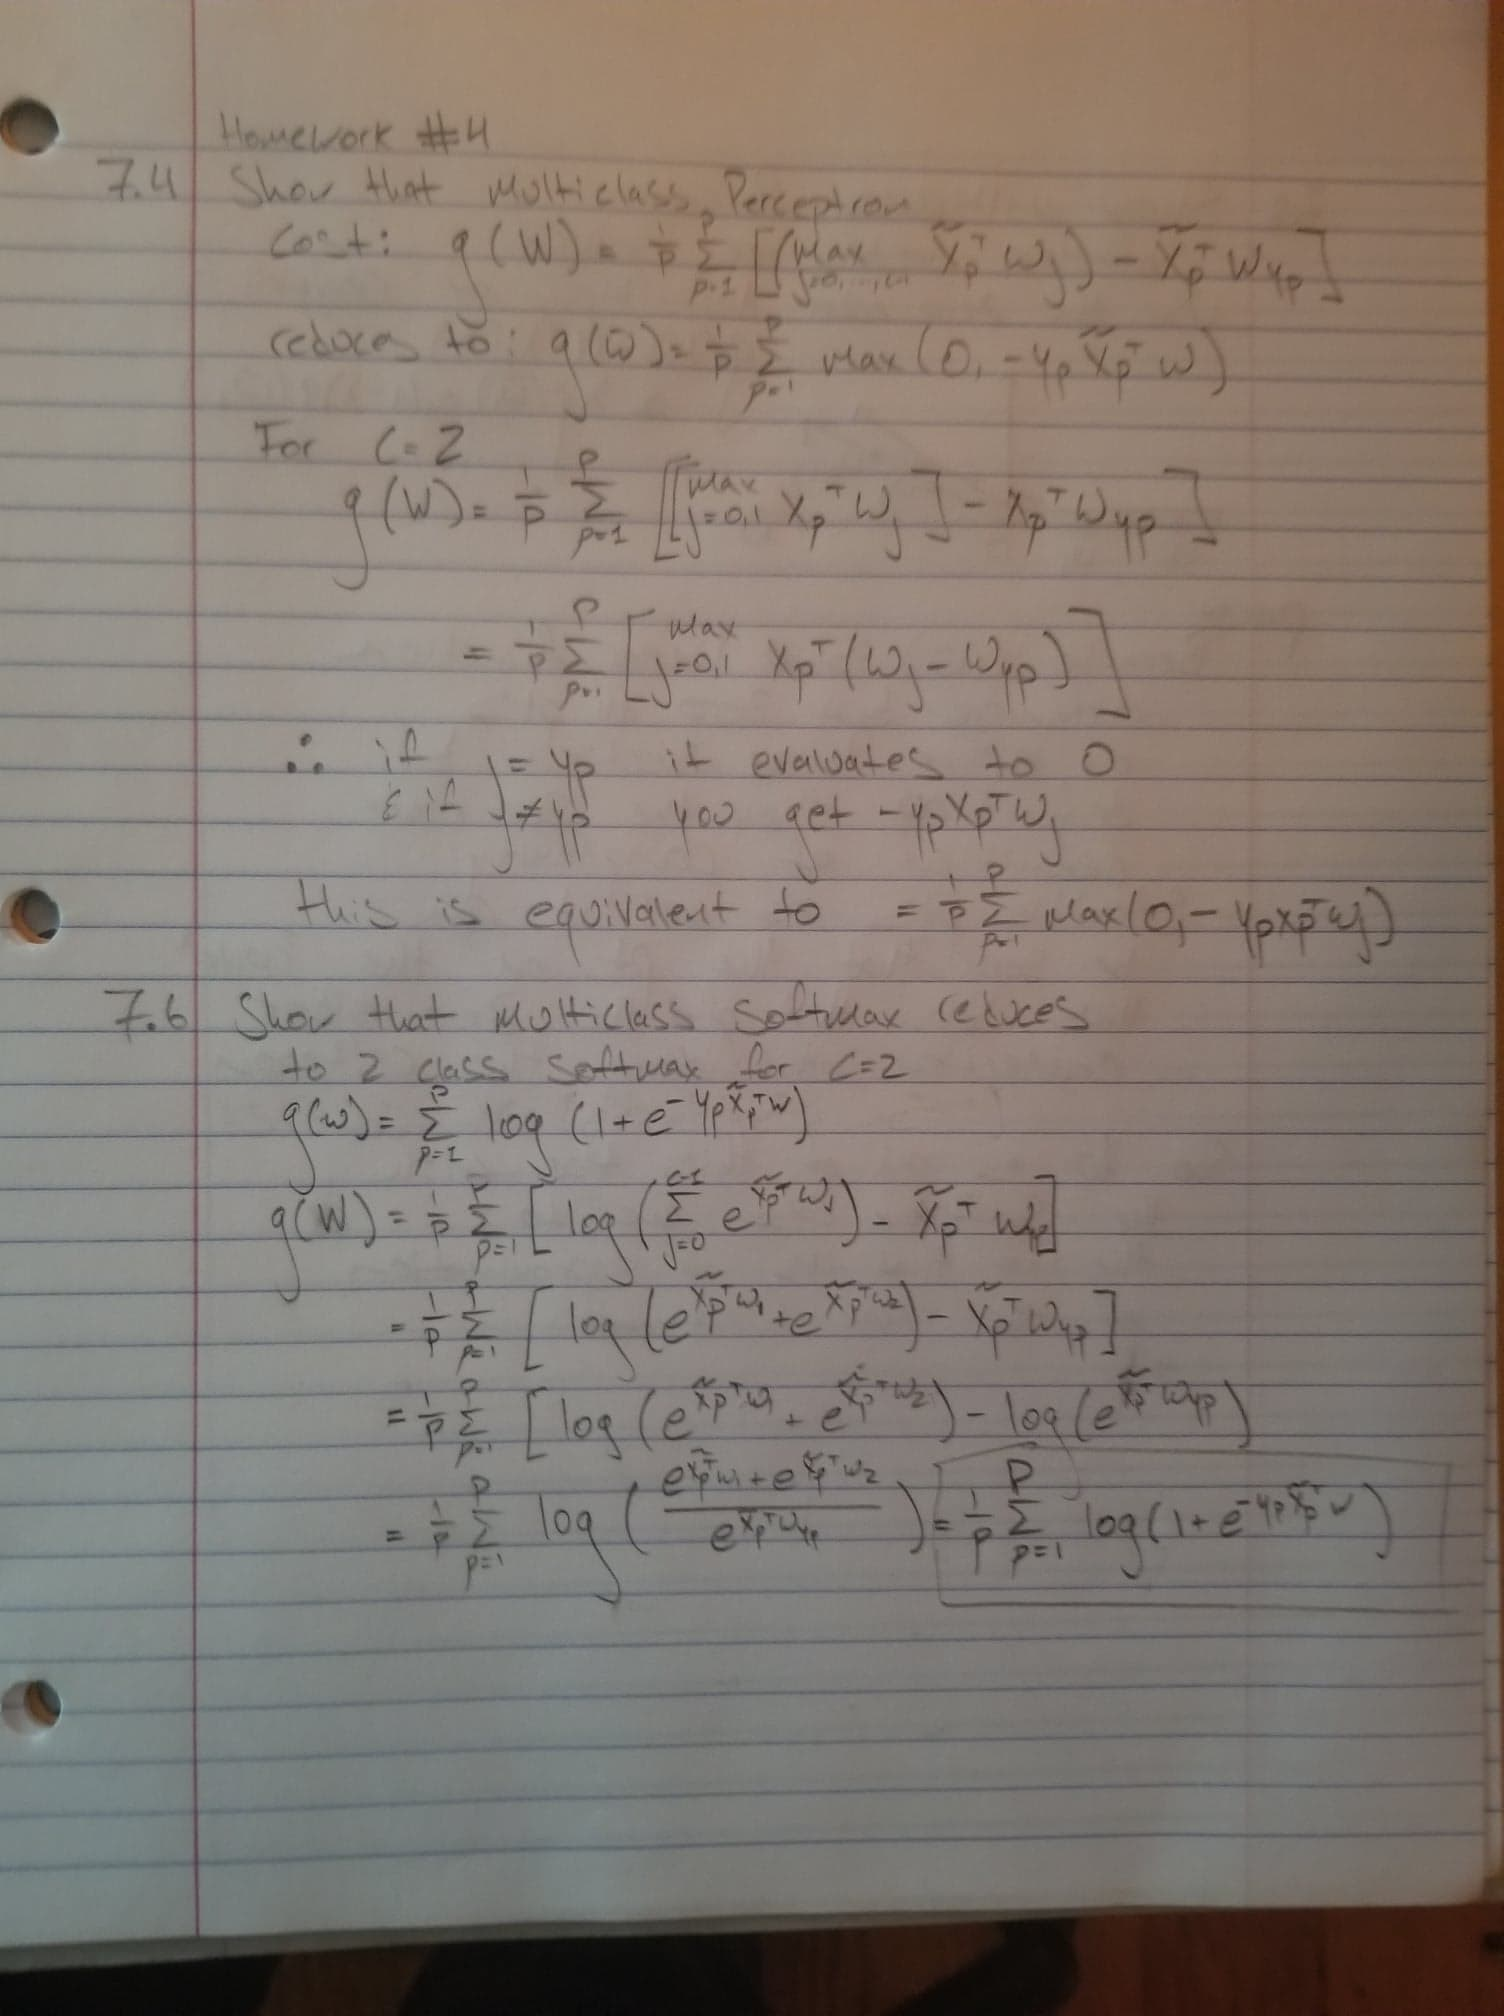

In [145]:
Image("p12.jpg")

## Problem 7.8

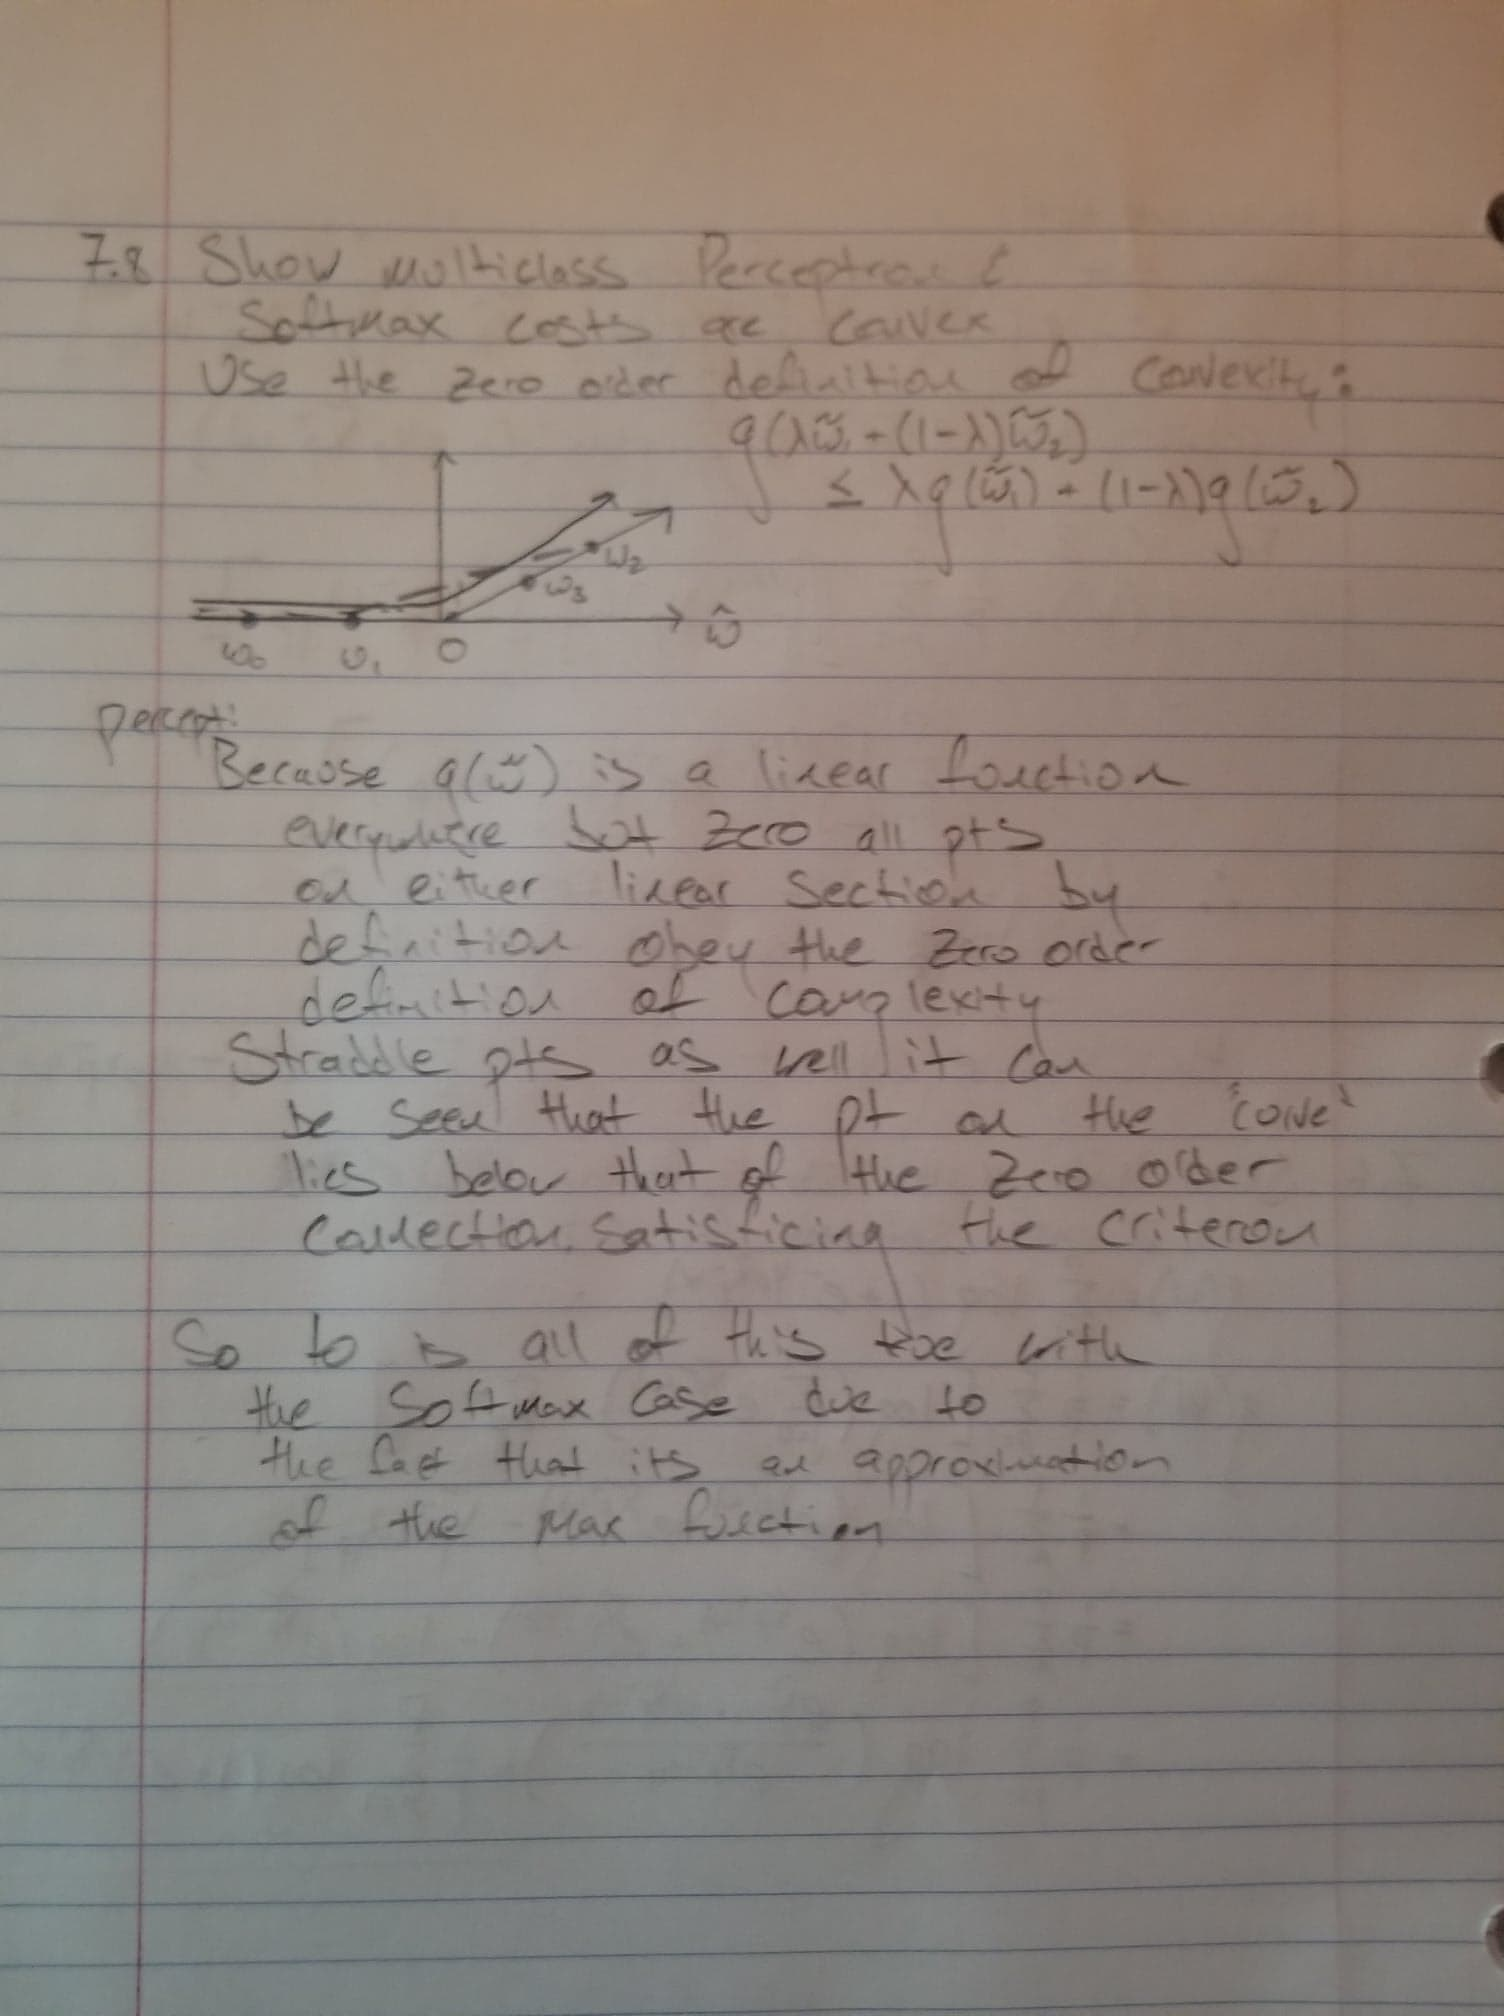

In [146]:
Image("p13.jpg")